Importing Libraries

In [1]:
#import keras as ke
import tensorflow as tf
import sys


import json
import math
import keras
import keras.backend as K



import numpy as np
import pickle
import cv2
import pandas as pd
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization


from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import layers, optimizers
from keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.losses import categorical_crossentropy
#from keras.optimizers import adam, sgd

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D

from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

In [2]:
print(tf.__version__) 
print(keras.__version__) 

2.4.1
2.4.3


In [3]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 42
#default_image_size = tuple((256, 256))

default_image_size = tuple((224, 224))

image_size = 0
directory_root = '../input/plantdisease/plantvillage/'
width=224
height=224
depth=3

**Converting Image Into the Array**

In [4]:
# function to convert images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size) 
          #  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

*Fetching the images in directory*

In [5]:
#Fetch images in the directory

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)


    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        copy=listdir(f"{directory_root}/{plant_folder}")
        plant_list = []
        print(plant_disease_folder_list)
        for disease_folder in copy :
            # remove .DS_Store from list
            print(disease_folder)
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:350]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']
Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Process

In [6]:
#get size of the processed images
image_size = len(image_list)
print(image_size)
print(len(label_list))

5052
5052


In [7]:
image_list[0].shape


(224, 224, 3)

Transform Image Labels using Scikit Learn's LabelBinarizer

In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

**Print the number of classes**

In [9]:
print(n_classes)

15


*Print the classes*

In [10]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [11]:
print(np.array(image_list[0]).dtype)

float32


In [13]:
image_list = np.array(image_list, dtype=np.float32)

In [14]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(image_list, image_labels, test_size=0.2, random_state = 42) 
#changed random state from 10 to 24

[INFO] Spliting data to train, test


In [15]:
aug = ImageDataGenerator(
            rotation_range=25, width_shift_range=0.1,
          height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

**Convolutional Neural Network**

![](https://miro.medium.com/max/875/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)

In [16]:
from keras.applications import ResNet50

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet.layers[:-4]:
    layer.trainable = False

def nvidia_model():
    model = Sequential()
    model.add(resnet)

    #comment out
   # model.add(MaxPooling2D(pool_size=(2, 2)))
   # model.add(Dropout(0.5))
    
    model.add(Flatten())
    
  
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
  
      
    
    model.add(Dense(15,activation='softmax'))
    optimizer = Adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
Total params: 74,976,143
Trainable params: 52,443,151
Non-trainable params: 22,532,992
_________________________________________________________________
None


In [17]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss',verbose=1,save_best_only=True, mode='auto')

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=40, verbose=1,
    callbacks=[checkpoint]
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
96/96 [==============================] - 47s 430ms/step - loss: 17.1709 - accuracy: 0.4305 - val_loss: 0.7941 - val_accuracy: 0.7606

Epoch 00001: val_loss improved from inf to 0.79412, saving model to model.h5
Epoch 2/40
96/96 [==============================] - 38s 399ms/step - loss: 0.6859 - accuracy: 0.7823 - val_loss: 0.6507 - val_accuracy: 0.8299

Epoch 00002: val_loss improved from 0.79412 to 0.65074, saving model to model.h5
Epoch 3/40
96/96 [==============================] - 38s 398ms/step - loss: 0.5604 - accuracy: 0.8319 - val_loss: 0.5354 - val_accuracy: 0.8487

Epoch 00003: val_loss improved from 0.65074 to 0.53540, saving model to model.h5
Epoch 4/40
96/96 [==============================] - 38s 395ms/step - loss: 0.4448 - accuracy: 0.8548 - val_loss: 0.4746 - val_accuracy: 0.8773

Epoch 00004: val_loss improved from 0.53540 to 0.47455, saving model to model.h5
Epoch 5/40
96/96 [==============================] - 39s 401ms/step - loss: 0.4102 - accuracy: 0.8787 - 

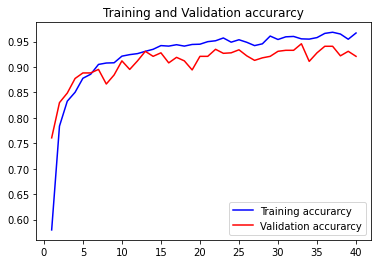

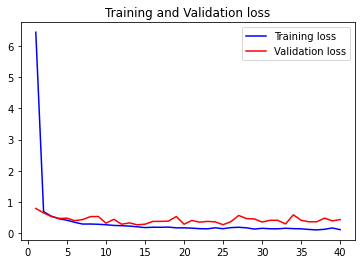

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation lossvv
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [19]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
32/32 [==============================] - 2s 58ms/step - loss: 0.4366 - accuracy: 0.9209
Test Accuracy: 92.08704233169556


In [20]:
from keras.models import load_model
model = load_model('model.h5')

In [21]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float32)
    print(np_image.dtype)
    np_image = np.expand_dims(np_image,0)
    print(np_image.shape)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image) 
    print(result)
    print((label_binarizer.classes_[result]))
    

float32
(1, 224, 224, 3)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[11]
['Tomato__Target_Spot']


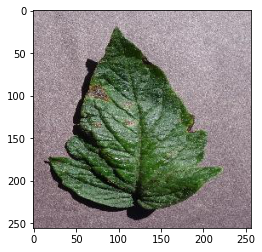

In [22]:
predict_disease("../input/plantdisease/PlantVillage/Tomato_Early_blight/00c5c908-fc25-4710-a109-db143da23112___RS_Erly.B 7778.JPG")

In [23]:
image="../input/plantdisease/PlantVillage/Tomato__Tomato_mosaic_virus/0dae2780-43e7-40ac-ae45-95e5318c8f32___PSU_CG 2290.JPG"

float32
(1, 224, 224, 3)
[13]
['Tomato__Tomato_mosaic_virus']


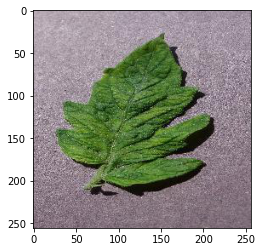

In [24]:
predict_disease(image)

float32
(1, 224, 224, 3)
[2]
['Potato___Early_blight']


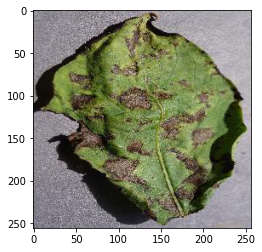

In [25]:
predict_disease("../input/plantdisease/PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG")

float32
(1, 224, 224, 3)
[8]
['Tomato_Leaf_Mold']


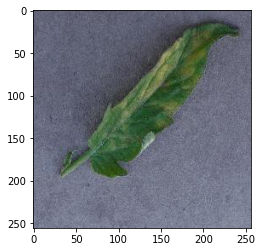

In [26]:
predict_disease("../input/plantdisease/PlantVillage/Tomato_Leaf_Mold/02a29ab9-8cba-47a0-bc2f-e7af7dbae149___Crnl_L.Mold 7165.JPG")

In [27]:
#convert keras model to tflite
model = tf.keras.models.load_model('model.h5')
converter =  tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("plant.tflite", "wb").write(tflite_model)

299527940

In [28]:
model.save('model_cnn.h5')